In [993]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import glob
import matplotlib.pyplot as plt
from faker import Faker
from datetime import date

# Importing 30 CSV files

In [994]:
path = '/Users/andrewtaylor/Desktop/Data_Science/Yale/MedHub/MedHub_Reports' 
csv_files = glob.glob(os.path.join(path, "*.xlsx"))
len(csv_files)

30

In [995]:
#creating a single DataFrame for the 30 previously read xlsx files

all_data = pd.DataFrame()
    
for f in csv_files:
    # reading 1 file at a time from the csv_files variable
    file, row = pd.read_excel(f), pd.read_excel(f)
    # slicing down to the 3rd row because there are rows that are irrelevant at the top of each file
    file = file.iloc[3:, :]
    
    # concatenating the spreadsheets under one another
    all_data = pd.concat([all_data, file])

In [996]:
# resetting the index and saving it to the DataFrame

all_data.reset_index(inplace = True, drop = True)

# Data Cleaning/Manipulation

In [997]:
# pulling a list of the column headers, which fell within the dataset on the 3rd index, as opposed to the headers

row_list = row.loc[3, :].values.flatten().tolist()[:12]

In [998]:
# viewing the list that was located in the 3rd index
row_list

['Evaluator:',
 'Evaluation:',
 'Type:',
 'Target:',
 'Delivery Method:',
 'Service:',
 'Clinic:',
 'Rotation:',
 'Status:',
 'Issued:',
 'Completed:',
 'Expiration Date:']

In [999]:
# applying the row_list of column headers to the header of columns
all_data = all_data.set_axis(row_list, axis =1)[1:].reset_index(drop = True)

In [1000]:
all_data.columns = row_list

In [1001]:
# there is unseen white space within the columns. they need to be removed in order to efficiently filter the data
all_data[all_data.columns] = all_data.apply(lambda x: x.str.strip())

In [1002]:
# removing rows in which the Evaluation column contains Semi Annual, CCC, and SOC. Those are not evaluation that we would like to consider
# in this analysis

all_data = all_data[all_data["Evaluation:"].str.contains('SemiAnnual', case = False)==False]
all_data = all_data[all_data["Evaluation:"].str.contains('CCC', case = False)==False]
all_data = all_data[all_data["Evaluation:"].str.contains('SOC', case = False)==False]
all_data = all_data[all_data["Status:"].str.contains('Status:', case = False)==False]

# only keeping rows of data that are faculty evaluations of a resident
all_data = all_data.loc[(all_data['Type:'] == 'Faculty evaluation of a resident')|(all_data['Type:'] == 'Faculty evaluation of a student')]

# filtering the data to only include Complete and Incomplete evaluations, 
# effectively dropping Expired, and Partially Complete
all_data = all_data.loc[(all_data['Status:'] == 'Complete') | (all_data['Status:'] == 'Incomplete')]

In [1003]:
all_data.shape

(1965, 12)

In [1004]:
all_data['Status:'].value_counts()

Complete      1463
Incomplete     502
Name: Status:, dtype: int64

In [1005]:
all_data.shape

(1965, 12)

In [1006]:
# removing duplicate evaluations
all_data = all_data.drop_duplicates()

In [1007]:
all_data.shape

(1964, 12)

In [1008]:
#removing "Dr" from all cells in Evaluator column

all_data['Evaluator:'] = all_data['Evaluator:'].map(lambda x: x.lstrip('Dr.'))

In [1009]:
#chopping the extra data off in the Evaluation column at the '-' symbol

all_data['Evaluation:'] = all_data['Evaluation:'].str.split('-', expand = True)[0]

In [1010]:
# changing the evaluation column to a string data type
all_data['Evaluation:'] = all_data['Evaluation:'].astype('str')

In [1011]:
#removing "Dr" from all cells in Evaluation column
all_data['Evaluation:'] = all_data['Evaluation:'].map(lambda x: x.lstrip('Dr.'))

In [1012]:
# checking data info
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 4209
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Evaluator:        1964 non-null   object
 1   Evaluation:       1964 non-null   object
 2   Type:             1964 non-null   object
 3   Target:           1964 non-null   object
 4   Delivery Method:  1964 non-null   object
 5   Service:          1964 non-null   object
 6   Clinic:           1964 non-null   object
 7   Rotation:         1964 non-null   object
 8   Status:           1964 non-null   object
 9   Issued:           1964 non-null   object
 10  Completed:        1964 non-null   object
 11  Expiration Date:  1964 non-null   object
dtypes: object(12)
memory usage: 199.5+ KB


In [1013]:
# selecting the columns i would like to use

all_data = all_data[['Evaluator:', 'Evaluation:','Type:', 'Status:','Issued:','Completed:', 'Rotation:']]

In [1014]:
# there is unseen white space within the columns. they need to be removed in order to efficiently filter the data
all_data[all_data.columns] = all_data.apply(lambda x: x.str.strip())

In [1015]:
# there are dashes in the Completed column. replacing that with NAN
all_data = all_data.replace('- -', np.nan)

In [1016]:
# removing the colons from the column headers by renaming the column
all_data.columns = ['Evaluator', 'Evaluation','Type','Status','Issued','Completed', 'Rotation']

In [1017]:
all_data['Completed'].value_counts().sum()

1463

In [1018]:
# reading in faculty list to concatenate faculty email address and correvt Academic Unit to dataset based on Last Name, First Name
faculty_list = pd.read_excel('/Users/andrewtaylor/Desktop/Data_Science/Yale/MedHub/Faculty List.xlsx')

In [1019]:
# creating a column that consists of last name and first name separated by a comma and a space
faculty_list['Name'] = faculty_list['Last Name'] + ", " + faculty_list['First Name']

# selecting name and email address columns
faculty_list = faculty_list[['Name','Academic Unit']]

In [1020]:
# merging the data so that the correct email address is appended to the correct person
all_data = all_data.merge(faculty_list, left_on = 'Evaluator', right_on = 'Name', how = 'inner')

In [1021]:
all_data = all_data.drop(['Name'], axis = 1)

In [1022]:
# creating a list of fake names to annonymize my dataset

faker = Faker()

# seed the random generator to produce the same results
Faker.seed(4321)

# creating fake names for Evaluator column
dict_names = {name: faker.name() for name in all_data['Evaluator'].unique()}
all_data['Evaluator'] = all_data['Evaluator'].map(dict_names)

# creatin fakes names for evaluation column
dict_names = {name: faker.name() for name in all_data['Evaluation'].unique()}
all_data['Evaluation'] = (all_data['Evaluation'].map(dict_names))
                                                

all_data.head()

,Evaluator,Evaluation,Type,Status,Issued,Completed,Rotation,Academic Unit
0,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Incomplete,3/6/2023,NaN,2/1-2/28/2023,Endocrinology
1,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Complete,1/6/2023,2/5/2023,12/1-12/31/2022,Endocrinology
2,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,12/19/2022,2/5/2023,10/1-10/31/2022,Endocrinology
3,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,9/29/2022,12/6/2022,9/1-9/30/2022,Endocrinology
4,Jason Brown,Lawrence Ramos,Faculty evaluation of a student,Complete,11/3/2022,12/6/2022,10/24-11/4/2022,Endocrinology


In [1023]:
final_features = all_data.copy()
final_features

,Evaluator,Evaluation,Type,Status,Issued,Completed,Rotation,Academic Unit
0,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Incomplete,3/6/2023,NaN,2/1-2/28/2023,Endocrinology
1,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Complete,1/6/2023,2/5/2023,12/1-12/31/2022,Endocrinology
2,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,12/19/2022,2/5/2023,10/1-10/31/2022,Endocrinology
3,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,9/29/2022,12/6/2022,9/1-9/30/2022,Endocrinology
4,Jason Brown,Lawrence Ramos,Faculty evaluation of a student,Complete,11/3/2022,12/6/2022,10/24-11/4/2022,Endocrinology
...,...,...,...,...,...,...,...,...
1645,Curtis Cross,Eric Hoffman,Faculty evaluation of a resident,Complete,9/1/2022,9/27/2022,NaN,Neurology (Pediatrics)
1646,Curtis Cross,Christopher Lopez,Faculty evaluation of a resident,Complete,8/25/2022,9/27/2022,NaN,Neurology (Pediatrics)
1647,Curtis Cross,Eric Hoffman,Faculty evaluation of a resident,Complete,8/25/2022,10/4/2022,NaN,Neurology (Pediatrics)
1648,Christopher Martinez,Jacqueline Carter,Faculty evaluation of a resident,Complete,8/16/2022,8/23/2022,8/3-8/16/2022,Emergency Medicine


In [1024]:
final_features.to_csv('demo_full_raw_data.csv')

In [1025]:
# saving a copy of the features datset to rates
rates = final_features.copy()

In [1026]:
rates['Issued'], rates['Completed'] = pd.to_datetime(rates['Issued']), pd.to_datetime(rates['Completed'])

In [1027]:
rates

,Evaluator,Evaluation,Type,Status,Issued,Completed,Rotation,Academic Unit
0,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Incomplete,2023-03-06,NaT,2/1-2/28/2023,Endocrinology
1,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Complete,2023-01-06,2023-02-05,12/1-12/31/2022,Endocrinology
2,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,2022-12-19,2023-02-05,10/1-10/31/2022,Endocrinology
3,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,2022-09-29,2022-12-06,9/1-9/30/2022,Endocrinology
4,Jason Brown,Lawrence Ramos,Faculty evaluation of a student,Complete,2022-11-03,2022-12-06,10/24-11/4/2022,Endocrinology
...,...,...,...,...,...,...,...,...
1645,Curtis Cross,Eric Hoffman,Faculty evaluation of a resident,Complete,2022-09-01,2022-09-27,NaN,Neurology (Pediatrics)
1646,Curtis Cross,Christopher Lopez,Faculty evaluation of a resident,Complete,2022-08-25,2022-09-27,NaN,Neurology (Pediatrics)
1647,Curtis Cross,Eric Hoffman,Faculty evaluation of a resident,Complete,2022-08-25,2022-10-04,NaN,Neurology (Pediatrics)
1648,Christopher Martinez,Jacqueline Carter,Faculty evaluation of a resident,Complete,2022-08-16,2022-08-23,8/3-8/16/2022,Emergency Medicine


In [1028]:
# creating a column called incomplete_as_of
# WHY?: Where a row has a status of "incomplete", the complete cell is NAN... I want that to be a date,
# so that i can use it to add and subtract from other dates. So I am filling it with a date that will be
# date.today(), so whenever the report is ran, it has a date of that date the report is ran.

from datetime import date
# using the rates dataset to filter rows where the status = incomplete. saving new dataset to incomplete_col
incomplete_col  = rates.loc[rates['Status'] == 'Incomplete']

# creating a column called "incomplete as of" , and filling NAs the completed tab with todays date
incomplete_col['Incomplete as Of'] = incomplete_col['Completed'].fillna(date.today())

# changing the data type to date_time, so it can be subtracted/added to other dates of the same type
incomplete_col['Incomplete as Of'] = pd.DataFrame(pd.to_datetime(incomplete_col['Incomplete as Of']))

#saving only the Incomplete as of column to the incomplete_col variable
incomplete_col = incomplete_col['Incomplete as Of']

/var/folders/0p/p58ht82n5l7dt1tyyssbh6dh0000gn/T/ipykernel_24745/2167426754.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_col['Incomplete as Of'] = incomplete_col['Completed'].fillna(date.today())
/var/folders/0p/p58ht82n5l7dt1tyyssbh6dh0000gn/T/ipykernel_24745/2167426754.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_col['Incomplete as Of'] = pd.DataFrame(pd.to_datetime(incomplete_col['Incomplete as Of']))


In [1029]:
# joining the incomplete_col to the full rates data set by index, so the merge happens on the same index
# only index with there is an NAN will be impacted, being filled with the date the day the report is ran

rates = rates.join(incomplete_col)
rates.head()

,Evaluator,Evaluation,Type,Status,Issued,Completed,Rotation,Academic Unit,Incomplete as Of
0,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Incomplete,2023-03-06,NaT,2/1-2/28/2023,Endocrinology,2023-03-27
1,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Complete,2023-01-06,2023-02-05,12/1-12/31/2022,Endocrinology,NaT
2,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,2022-12-19,2023-02-05,10/1-10/31/2022,Endocrinology,NaT
3,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,2022-09-29,2022-12-06,9/1-9/30/2022,Endocrinology,NaT
4,Jason Brown,Lawrence Ramos,Faculty evaluation of a student,Complete,2022-11-03,2022-12-06,10/24-11/4/2022,Endocrinology,NaT


In [1030]:
rates.dtypes

Evaluator                   object
Evaluation                  object
Type                        object
Status                      object
Issued              datetime64[ns]
Completed           datetime64[ns]
Rotation                    object
Academic Unit               object
Incomplete as Of    datetime64[ns]
dtype: object

# Data Manipulation
### Creating additional columns to express how many evaluations are being completed/left incomplete on a weekly basis

In [1031]:
# subtracting the "completed" column date from the 'issued' column date to define a "AVG Time to Complete" column

rates['AVG Time to Complete'] = pd.to_datetime(rates['Completed']) - pd.to_datetime(rates['Issued'])

In [1032]:
rates.head()

,Evaluator,Evaluation,Type,Status,Issued,Completed,Rotation,Academic Unit,Incomplete as Of,AVG Time to Complete
0,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Incomplete,2023-03-06,NaT,2/1-2/28/2023,Endocrinology,2023-03-27,NaT
1,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Complete,2023-01-06,2023-02-05,12/1-12/31/2022,Endocrinology,NaT,30 days
2,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,2022-12-19,2023-02-05,10/1-10/31/2022,Endocrinology,NaT,48 days
3,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,2022-09-29,2022-12-06,9/1-9/30/2022,Endocrinology,NaT,68 days
4,Jason Brown,Lawrence Ramos,Faculty evaluation of a student,Complete,2022-11-03,2022-12-06,10/24-11/4/2022,Endocrinology,NaT,33 days


In [1033]:
# updating the data types
#rates['Incomplete as Of'] = pd.to_datetime(rates['Incomplete as Of'])


# subtracting the "incomplete as of" column (todays date) from the date thart the eval was issued,
# to define an "Incomplete for" column
rates['Incomplete for'] = pd.to_datetime(rates['Incomplete as Of']) - pd.to_datetime(rates['Issued'])

In [1034]:
fac_avg_comp = rates
rates.head()

,Evaluator,Evaluation,Type,Status,Issued,Completed,Rotation,Academic Unit,Incomplete as Of,AVG Time to Complete,Incomplete for
0,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Incomplete,2023-03-06,NaT,2/1-2/28/2023,Endocrinology,2023-03-27,NaT,21 days
1,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Complete,2023-01-06,2023-02-05,12/1-12/31/2022,Endocrinology,NaT,30 days,NaT
2,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,2022-12-19,2023-02-05,10/1-10/31/2022,Endocrinology,NaT,48 days,NaT
3,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,2022-09-29,2022-12-06,9/1-9/30/2022,Endocrinology,NaT,68 days,NaT
4,Jason Brown,Lawrence Ramos,Faculty evaluation of a student,Complete,2022-11-03,2022-12-06,10/24-11/4/2022,Endocrinology,NaT,33 days,NaT


In [1035]:
# reseting the index (numbers along the left side). inplace = True saves the change to the dataset
rates.reset_index(drop = True, inplace = True)

In [1036]:
# creating column (grouped by week) for evals that were completed in less than 14 days

less_than_14 = rates.loc[rates['AVG Time to Complete'] <= '14 days']
less_than_14 = less_than_14.groupby([pd.Grouper(key='Issued',
                                                freq = 'W')]).agg(Completed_Within_14 = ('AVG Time to Complete','count'))
less_than_14.head()

,Completed_Within_14
Issued,
2022-07-03,1
2022-07-10,6
2022-07-17,15
2022-07-24,19
2022-07-31,22


In [1037]:
# creating column (grouped by week) for evals that were completed in 15-30 days

btw_15_30 = rates.loc[(rates['AVG Time to Complete'] >= '15 days') & (rates['AVG Time to Complete'] <= '30 days')]
btw_15_30 = btw_15_30.groupby([pd.Grouper(key='Issued', freq = 'W')]).agg(Completed_Within_15_30 = ('AVG Time to Complete',
                                                                                                    'count'))
btw_15_30.head()

,Completed_Within_15_30
Issued,
2022-07-03,1
2022-07-10,5
2022-07-17,3
2022-07-24,8
2022-07-31,2


In [1038]:
# creating column (grouped by week) for evals that were completed after 30 days

since_issue_30 = rates.loc[rates['AVG Time to Complete'] > '30 days']
since_issue_30 = since_issue_30.groupby([pd.Grouper(key='Issued', freq = 'W')]).agg(Completed_After_30 = ('AVG Time to Complete',
                                                                                                    'count'))
since_issue_30.head()

,Completed_After_30
Issued,
2022-07-10,4
2022-07-17,3
2022-07-24,4
2022-07-31,8
2022-08-07,5


In [1039]:
# creating column (grouped by week) for evals that were completed

complete = rates.loc[rates['AVG Time to Complete'] >= '0 days']
complete = complete.groupby([pd.Grouper(key='Issued', freq = 'W')]).agg(Total_Completed = ('AVG Time to Complete',
                                                                                                    'count'))
complete.head()

,Total_Completed
Issued,
2022-07-03,2
2022-07-10,15
2022-07-17,21
2022-07-24,31
2022-07-31,32


In [1040]:
# creating column (grouped by week) for evals that were incompleted and issued less than 14 days ago

Less_than_14 = rates.loc[rates['AVG Time to Complete'] <= '14 days']
Less_than_14 = Less_than_14.groupby([pd.Grouper(key='Issued', freq = 'W')]).agg(Incomplete_less_than_14_days = ('AVG Time to Complete',
                                                                                                    'count'))
Less_than_14.head()

,Incomplete_less_than_14_days
Issued,
2022-07-03,1
2022-07-10,6
2022-07-17,15
2022-07-24,19
2022-07-31,22


In [1041]:
# creating column (grouped by week) for evals that were incompleted and issued more than 14 days ago

More_14_days = rates.loc[rates['Incomplete for'] >= '15 days']
More_14_days = More_14_days.groupby([pd.Grouper(key='Issued', freq = 'W')]).agg(Incomplete_more_than_14_Days = ('Incomplete for',
                                                                                                    'count'))
More_14_days.head()

,Incomplete_more_than_14_Days
Issued,
2022-07-10,3
2022-07-17,5
2022-07-24,8
2022-07-31,9
2022-08-07,3


## Joining the previously created data frames

In [1042]:
# Joining recently defined columns

weekly_rates = less_than_14.join(btw_15_30).join(since_issue_30).join(complete).join(Less_than_14).join(More_14_days).fillna(0).reset_index()
weekly_rates.head()

,Issued,Completed_Within_14,Completed_Within_15_30,Completed_After_30,Total_Completed,Incomplete_less_than_14_days,Incomplete_more_than_14_Days
0,2022-07-03,1,1.0,0.0,2,1,0.0
1,2022-07-10,6,5.0,4.0,15,6,3.0
2,2022-07-17,15,3.0,3.0,21,15,5.0
3,2022-07-24,19,8.0,4.0,31,19,8.0
4,2022-07-31,22,2.0,8.0,32,22,9.0


## Creating columns sums the number of evaluations completed or incomplete by week

In [1043]:
# changing the datatypes 

weekly_rates['Incomplete_more_than_14_Days'] = weekly_rates['Incomplete_more_than_14_Days'].astype('Int64')

weekly_rates['Completed_Within_15_30'] = weekly_rates['Completed_Within_15_30'].astype('Int64')

weekly_rates['Completed_After_30'] = weekly_rates['Completed_After_30'].astype('Int64')

In [1044]:
weekly_rates['num_incomplete'] = weekly_rates['Incomplete_less_than_14_days'] + weekly_rates['Incomplete_more_than_14_Days']
weekly_rates.head()

,Issued,Completed_Within_14,Completed_Within_15_30,Completed_After_30,Total_Completed,Incomplete_less_than_14_days,Incomplete_more_than_14_Days,num_incomplete
0,2022-07-03,1,1,0,2,1,0,1
1,2022-07-10,6,5,4,15,6,3,9
2,2022-07-17,15,3,3,21,15,5,20
3,2022-07-24,19,8,4,31,19,8,27
4,2022-07-31,22,2,8,32,22,9,31


In [1045]:
weekly_rates['Total'] =  (weekly_rates['Total_Completed'] + weekly_rates['num_incomplete']).astype('Int64')
weekly_rates.head()

,Issued,Completed_Within_14,Completed_Within_15_30,Completed_After_30,Total_Completed,Incomplete_less_than_14_days,Incomplete_more_than_14_Days,num_incomplete,Total
0,2022-07-03,1,1,0,2,1,0,1,3
1,2022-07-10,6,5,4,15,6,3,9,24
2,2022-07-17,15,3,3,21,15,5,20,41
3,2022-07-24,19,8,4,31,19,8,27,58
4,2022-07-31,22,2,8,32,22,9,31,63


In [1046]:
weekly_rates.fillna(0, inplace = True)

In [1047]:
weekly_rates['Percent_incomplete'] = (weekly_rates['num_incomplete'].astype('Int64') / weekly_rates['Total'].astype('Int64'))

In [1048]:
weekly_rates['Percent_complete'] = (weekly_rates['Total_Completed'].astype('Int64') / weekly_rates['Total'].astype('Int64'))

In [1049]:
weekly_rates['Completed Within 14 Days'] = weekly_rates['Completed_Within_14'] / weekly_rates['Total_Completed']

In [1050]:
weekly_rates['Completed Within 15-30 Days'] = weekly_rates['Completed_Within_15_30'] / weekly_rates['Total_Completed']

In [1051]:
weekly_rates['Completed 30+ Days After Issue'] = weekly_rates['Completed_After_30'] / weekly_rates['Total_Completed']

In [1052]:
weekly_rates['% Complete'] = weekly_rates['Total_Completed'] / weekly_rates['Total']

In [1053]:
weekly_rates['Incomplete & < 14 Days Since Issue'] = weekly_rates['Incomplete_less_than_14_days'] / weekly_rates['num_incomplete'] 

In [1054]:
weekly_rates['Incomplete & > 14 Days Since Issue'] = weekly_rates['Incomplete_more_than_14_Days'] / weekly_rates['num_incomplete']

In [1055]:
final_rates = weekly_rates[['Issued','Completed Within 14 Days','Completed Within 15-30 Days','Completed 30+ Days After Issue',
        '% Complete','Incomplete & < 14 Days Since Issue','Incomplete & > 14 Days Since Issue',
        'Percent_incomplete']].round(2)

In [1056]:
final_rates.to_excel('demo_eval_completion_by_week.xlsx', index = False)
print('All Done!')

All Done!


In [1057]:
# evaluation completion rates by week
final_rates.head()

,Issued,Completed Within 14 Days,Completed Within 15-30 Days,Completed 30+ Days After Issue,% Complete,Incomplete & < 14 Days Since Issue,Incomplete & > 14 Days Since Issue,Percent_incomplete
0,2022-07-03,0.50,0.5,0.0,0.67,1.0,0.0,0.33
1,2022-07-10,0.40,0.33,0.27,0.62,0.67,0.33,0.38
2,2022-07-17,0.71,0.14,0.14,0.51,0.75,0.25,0.49
3,2022-07-24,0.61,0.26,0.13,0.53,0.7,0.3,0.47
4,2022-07-31,0.69,0.06,0.25,0.51,0.71,0.29,0.49


In [1058]:
final_features.head()

,Evaluator,Evaluation,Type,Status,Issued,Completed,Rotation,Academic Unit
0,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Incomplete,3/6/2023,NaN,2/1-2/28/2023,Endocrinology
1,Jason Brown,Jacqueline Ball,Faculty evaluation of a resident,Complete,1/6/2023,2/5/2023,12/1-12/31/2022,Endocrinology
2,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,12/19/2022,2/5/2023,10/1-10/31/2022,Endocrinology
3,Jason Brown,Christine Lane,Faculty evaluation of a resident,Complete,9/29/2022,12/6/2022,9/1-9/30/2022,Endocrinology
4,Jason Brown,Lawrence Ramos,Faculty evaluation of a student,Complete,11/3/2022,12/6/2022,10/24-11/4/2022,Endocrinology


Text(0.5, 1.0, 'Number of Evaluations per Section')

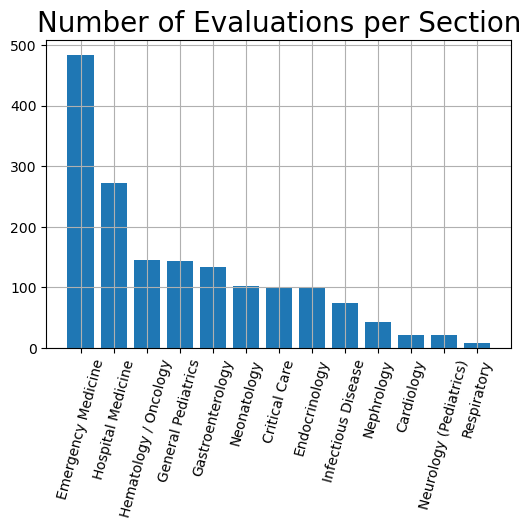

In [1059]:
# number of evals per academic unit
num_unit_evals = final_features.groupby('Academic Unit')['Issued'].count().reset_index().sort_values(by='Issued', ascending = False)

fig = plt.figure(figsize = (6,4))
plt.bar(num_unit_evals["Academic Unit"], num_unit_evals['Issued'])#, color = ['red','blue','yellow','purple','green','brown','teal'])
plt.xticks(rotation = 75)
plt.grid()
plt.title('Number of Evaluations per Section', size = 20)

In [1060]:
# number of evals per faculty

num_evals_per_faculty = final_features.groupby('Evaluator')['Issued'].count().reset_index().sort_values(by = 'Evaluator', ascending = True)
num_evals_per_faculty

# average time to complete evaluations by evaluator

avg_comp_time = rates.groupby('Evaluator')['AVG Time to Complete'].mean().reset_index().sort_values(by='Evaluator', ascending = True)
avg_comp_time

num_evals_avg_time = pd.merge(num_evals_per_faculty, avg_comp_time, on ='Evaluator')

num_evals_avg_time['AVG Time to Complete'] = num_evals_avg_time['AVG Time to Complete'].dt.days

num_evals_avg_time.head(3)

,Evaluator,Issued,AVG Time to Complete
0,Aaron Stokes,11,16.0
1,Aaron Walker,34,10.0
2,Adam Hoffman,7,12.0


In [1061]:
# average completion time by section
avg_comp_time_by_section = rates.groupby('Academic Unit')['AVG Time to Complete'].mean().reset_index().sort_values(by='AVG Time to Complete',
                                                                                                         ascending = False).reset_index(drop = True)

avg_comp_time_by_section['AVG Time to Complete'] = avg_comp_time_by_section['AVG Time to Complete'].dt.days

# creating a data frame to identify the number of evals by section

num_unit_evals = final_features.groupby('Academic Unit')['Issued'].count().reset_index().sort_values(by='Issued', ascending = False)

# merging the to previously created dataframes to identify  the number of evaluations and average time to complete by academic unit in one frame
num_avg_unit_evals = pd.merge(num_unit_evals, avg_comp_time_by_section, on = 'Academic Unit')
num_avg_unit_evals.head(3)

,Academic Unit,Issued,AVG Time to Complete
0,Emergency Medicine,484,16
1,Hospital Medicine,272,22
2,Hematology / Oncology,145,24


In [1062]:
# there is a small and siginificantly unimportant correlation between number of evaluations and average time to complete
num_avg_unit_evals.corr()

,Issued,AVG Time to Complete
Issued,1.000000,0.141054
AVG Time to Complete,0.141054,1.000000


Text(0.5, 1.0, 'Number of Evals Issued')

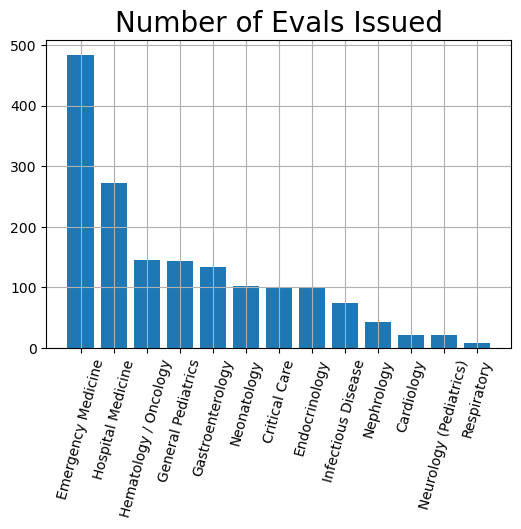

In [1063]:
# visualizating number of evaluations

fig = plt.figure(figsize = (6,4))
plt.bar(num_avg_unit_evals["Academic Unit"], num_avg_unit_evals['Issued'])#, color = ['red','blue','yellow','purple','green','brown','teal'])
plt.xticks(rotation = 75)
plt.grid()
plt.title('Number of Evals Issued', size = 20)

Text(0.5, 1.0, 'AVG Time to Complete')

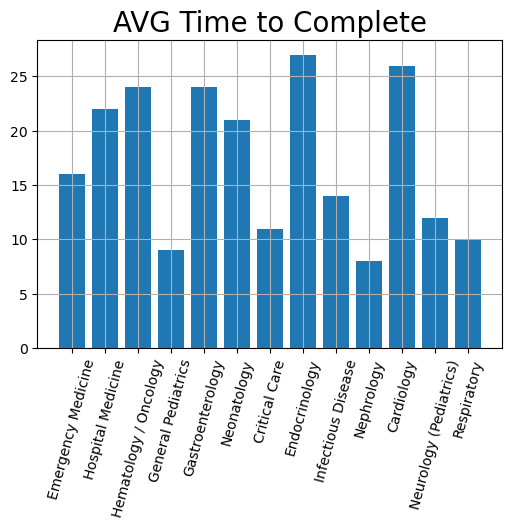

In [1064]:
# visualizating average time to complete

fig = plt.figure(figsize = (6,4))
plt.bar(num_avg_unit_evals["Academic Unit"], num_avg_unit_evals['AVG Time to Complete'])#, color = ['red','blue','yellow','purple','green','brown','teal'])
plt.xticks(rotation = 75)
plt.grid()
plt.title('AVG Time to Complete', size = 20)